# Spherical Gaussian experiment: generative results

## Setup

In [4]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [46]:
algo_filenames = [
    "flow",
    "pie",
    "mf",
    "gamf",
    "pie_specified",
    "mf_specified",
    "gamf_specified",
]
algo_additionals = [
    "",
    "",
    "",
    "_largebs", 
    "",
    "", 
    "",
]
algo_labels = [
    "Flow",
    "PIE",
    "MF",
    "MF-A",
    "PIE-S",
    "MF-S",
    "MF-AS",
]
algo_colors = [
    "0.6",
    "C1",
    "C3",
    "C0",
    "C1",
    "C3",
    "C0",
]
algo_markers = [
    "s",
    "s",
    "s",
    "s",
    "o",
    "o",
    "o",
]
algo_linestyles = [
    "-",
    "-",
    "-",
    "-",
    "--",
    "--",
    "--",
]

setup_filenames = [
    "2_3_0.010",
    "2_3_0.001",
    "2_3_0.100",
]
setup_labels = [
    r"$\epsilon = 0.01$",
    r"$\epsilon = 0.001$",
    r"$\epsilon = 0.1$",
]


In [23]:
def load(quantity, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add in zip(algo_filenames, algo_additionals):
        results = []
        
        for setup_filename in setup_filenames:
            try:
                results.append(np.load(
                    "{}/{}_2_spherical_gaussian_{}{}_{}.npy".format(
                        result_dir, algo_filename, setup_filename, algo_add, quantity
                    )
                ))
            except FileNotFoundError as e:
                print(e)
                
                if shape is None:
                    results.append(None)
                else:
                    results.append(np.nan*np.ones(shape))
            
        all_results.append(results)
    
    return np.asarray(all_results) if numpyfy else all_results

x_gen = load("samples", None, numpyfy=False)
logp_gen = load("samples_likelihood", (1000,))
distance_gen = load("samples_manifold_distance", (1000,))

true_test_log_likelihood = load("true_log_likelihood_test", (1000,))
model_test_log_likelihood = load("model_log_likelihood_test", (1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))

model_ood_log_likelihood = load("model_log_likelihood_ood", (1000,))
model_ood_reco_error = load("model_reco_error_ood", (1000,))


In [24]:
x_test = np.asarray([
    np.load("../data/samples/spherical_gaussian/spherical_gaussian_{}_x_test.npy".format(setup_filename))
    for setup_filename in setup_filenames
])

true_distances = np.abs(np.sum(x_test**2, axis=-1)**0.5 - 1.)

## Calculate metrics

In [48]:
min_logp = -100.
max_distance = 10.

mean_logp_gen = np.mean(np.clip(logp_gen, min_logp, None), axis=2)
mean_distance_gen = np.mean(np.clip(distance_gen, None, max_distance), axis=2)

mean_logp_truth = np.mean(np.clip(true_test_log_likelihood[0], min_logp, None), axis=1)
mean_distance_truth = np.mean(np.clip(true_distances, None, max_distance), axis=1)

In [49]:
def calculate_roc_auc(x0, x1):
    return np.asarray(
        [
            [
                np.maximum(
                    roc_auc_score(
                        np.hstack((np.zeros(this_x0.shape[0], dtype=np.int),
                                   np.ones(this_x1.shape[0], dtype=np.int))),
                        np.hstack((this_x0, this_x1)),
                    ),
                    roc_auc_score(
                        np.hstack((np.zeros(this_x0.shape[0], dtype=np.int),
                                   np.ones(this_x1.shape[0], dtype=np.int))),
                        - np.hstack((this_x0, this_x1)),
                    )
                )
                for this_x0, this_x1 in zip(x0_, x1_)
            ]
            for x0_, x1_ in zip(x0, x1)
        ]
    )


auc_logp = calculate_roc_auc(model_test_log_likelihood, model_ood_log_likelihood)
auc_err = calculate_roc_auc(model_test_reco_error, model_ood_reco_error)
auc_use_err = (auc_err > auc_logp)
auc_best = np.maximum(auc_err, auc_logp)

## Plot generated samples

In [50]:
def show_corner(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_test.npy")
        _ = corner.corner(x, range=[(-boundary, boundary) for _ in range(3)], bins=10)
        
    else:
        print(algo_labels[algo])
        _ = corner.corner(x_gen[algo][show], range=[(-boundary, boundary) for _ in range(3)], bins=10)
        
        
def show_scatter(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_train.npy")[:1000]
    else:
        print(algo_labels[algo])
        x = x_gen[algo][show][:1000]
        
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig)
    ax.scatter(x[:,0], x[:,1], x[:,2])
    
    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_zlabel("$x_2$")
    
    plt.show()
    

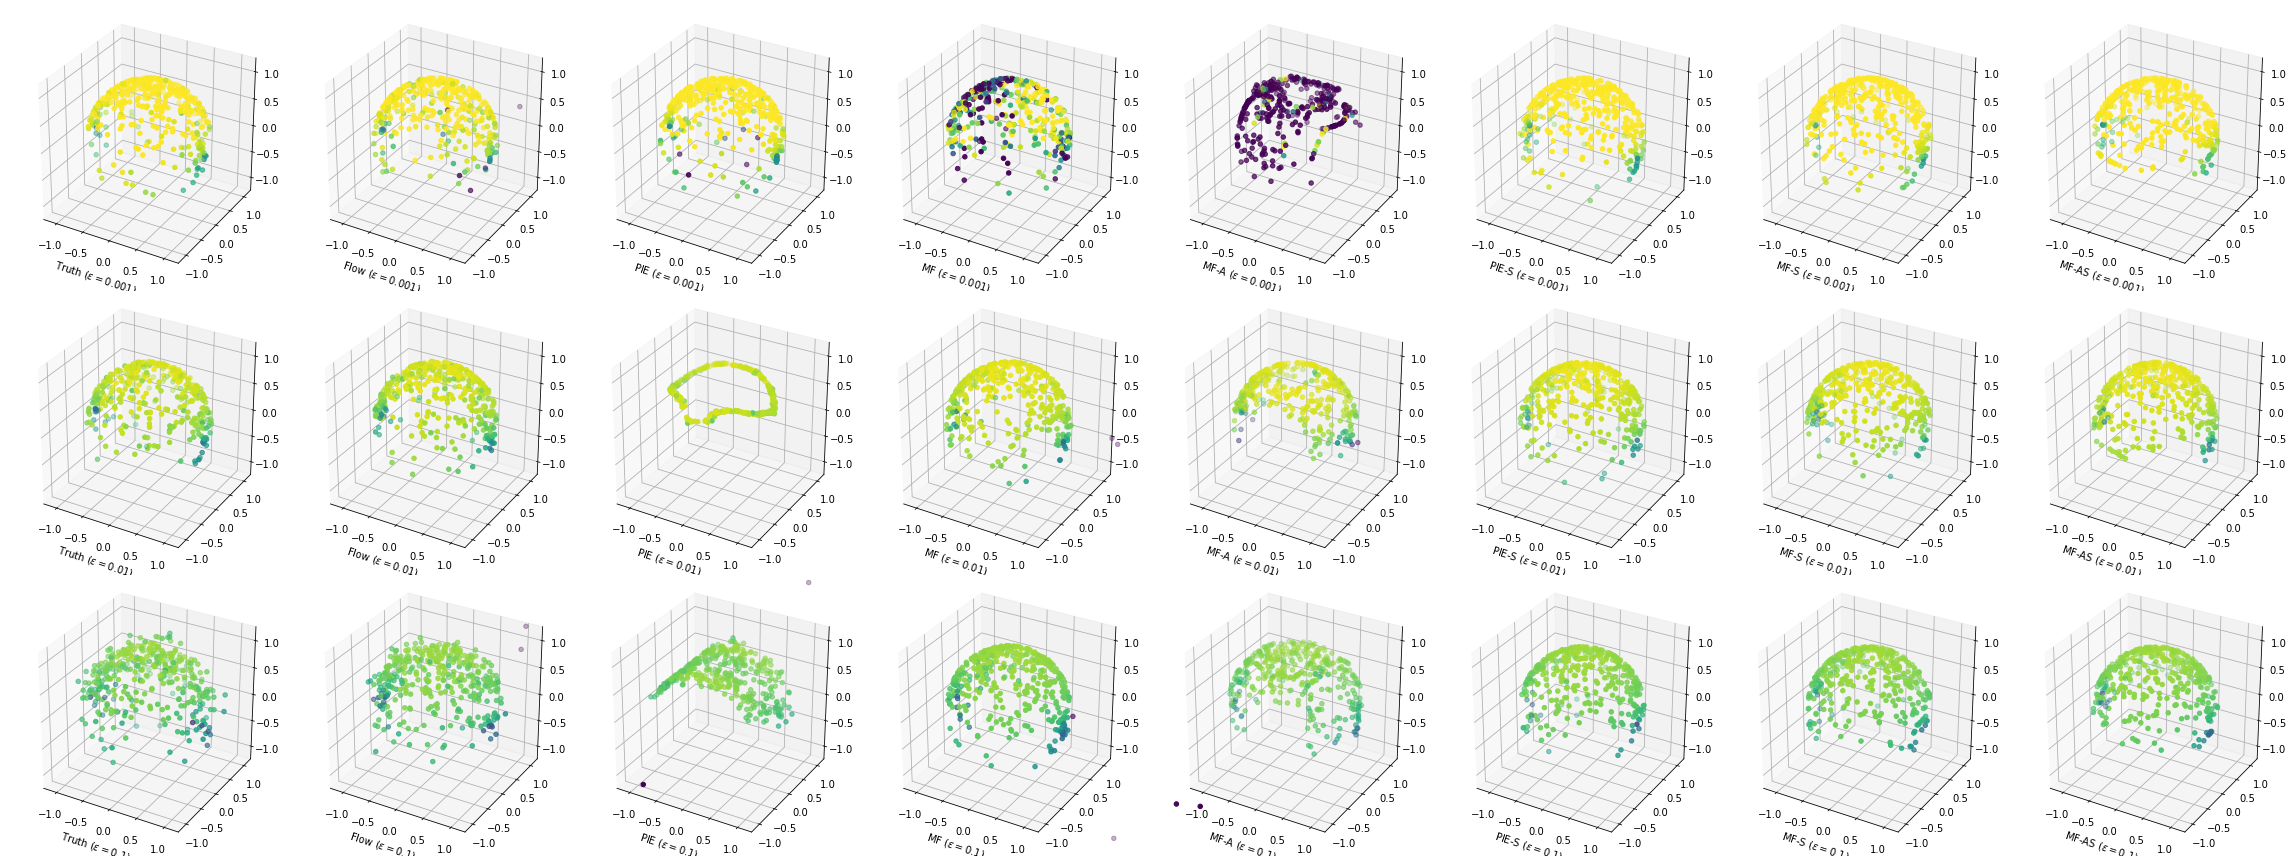

In [51]:
cmin, cmax = -15., 5.
boundary = 1.2
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        if algo < 0:
            x = x_test[setup, :400]
        else:
             x = x_gen[algo][setup][:400]
                
        logp = np.clip(
            true_test_log_likelihood[0, setup, :400] if algo < 0 else logp_gen[algo, setup,:400],
            cmin, cmax
        )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, cmap="viridis", vmin=cmin, vmax=cmax)

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        ax.set_xlabel(("Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel("")
        ax.set_zlabel("")

plt.tight_layout()
plt.savefig("../figures/generated_samples_3d_spherical_gaussian.pdf")



## Plot eval likelihood on test samples

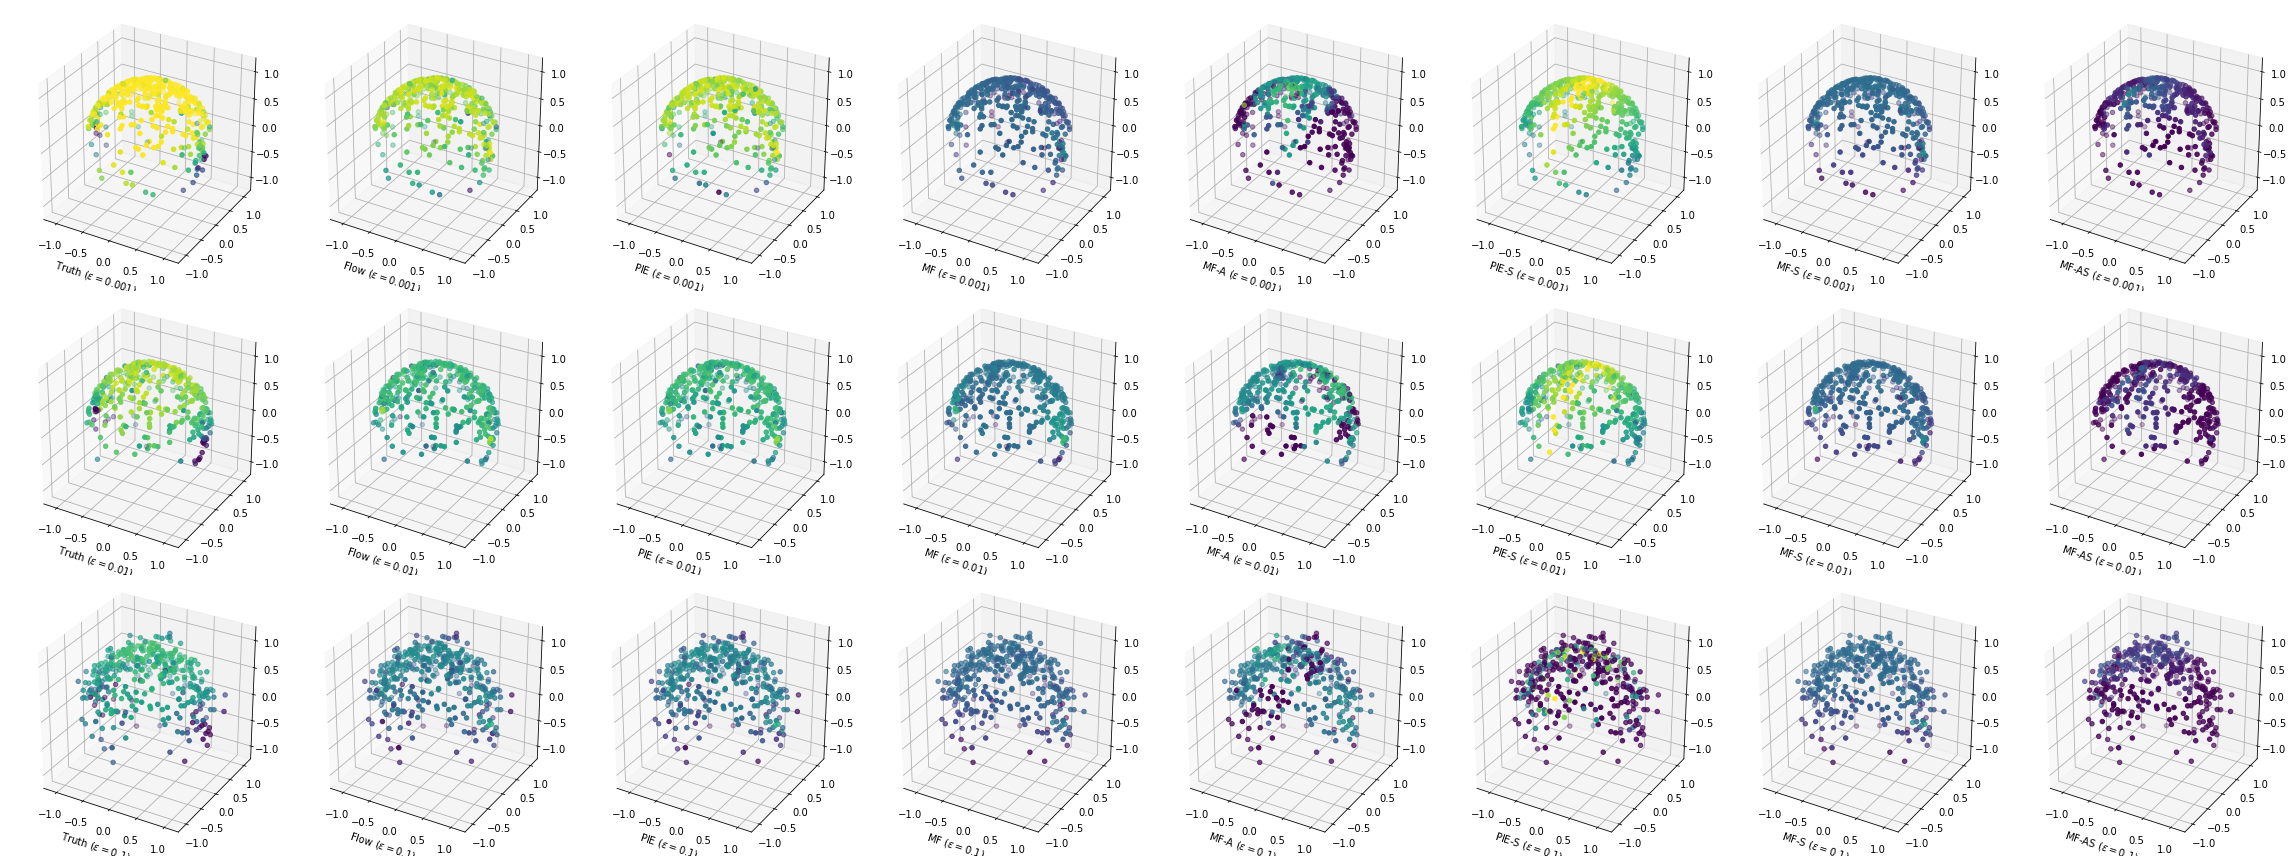

In [52]:
cmin, cmax = -5., 5.
boundary = 1.2
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        x = x_test[setup, :400]
        logp = np.clip(
            true_test_log_likelihood[0, setup, :400] if algo < 0 else model_test_log_likelihood[algo, setup,:400],
            cmin, cmax
        )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, vmin=cmin, vmax=cmax, cmap="viridis")

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        ax.set_xlabel(("Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel("")
        ax.set_zlabel("")

plt.tight_layout()
plt.savefig("../figures/test_likelihood_3d_spherical_gaussian.pdf")


## Evaluation metrics

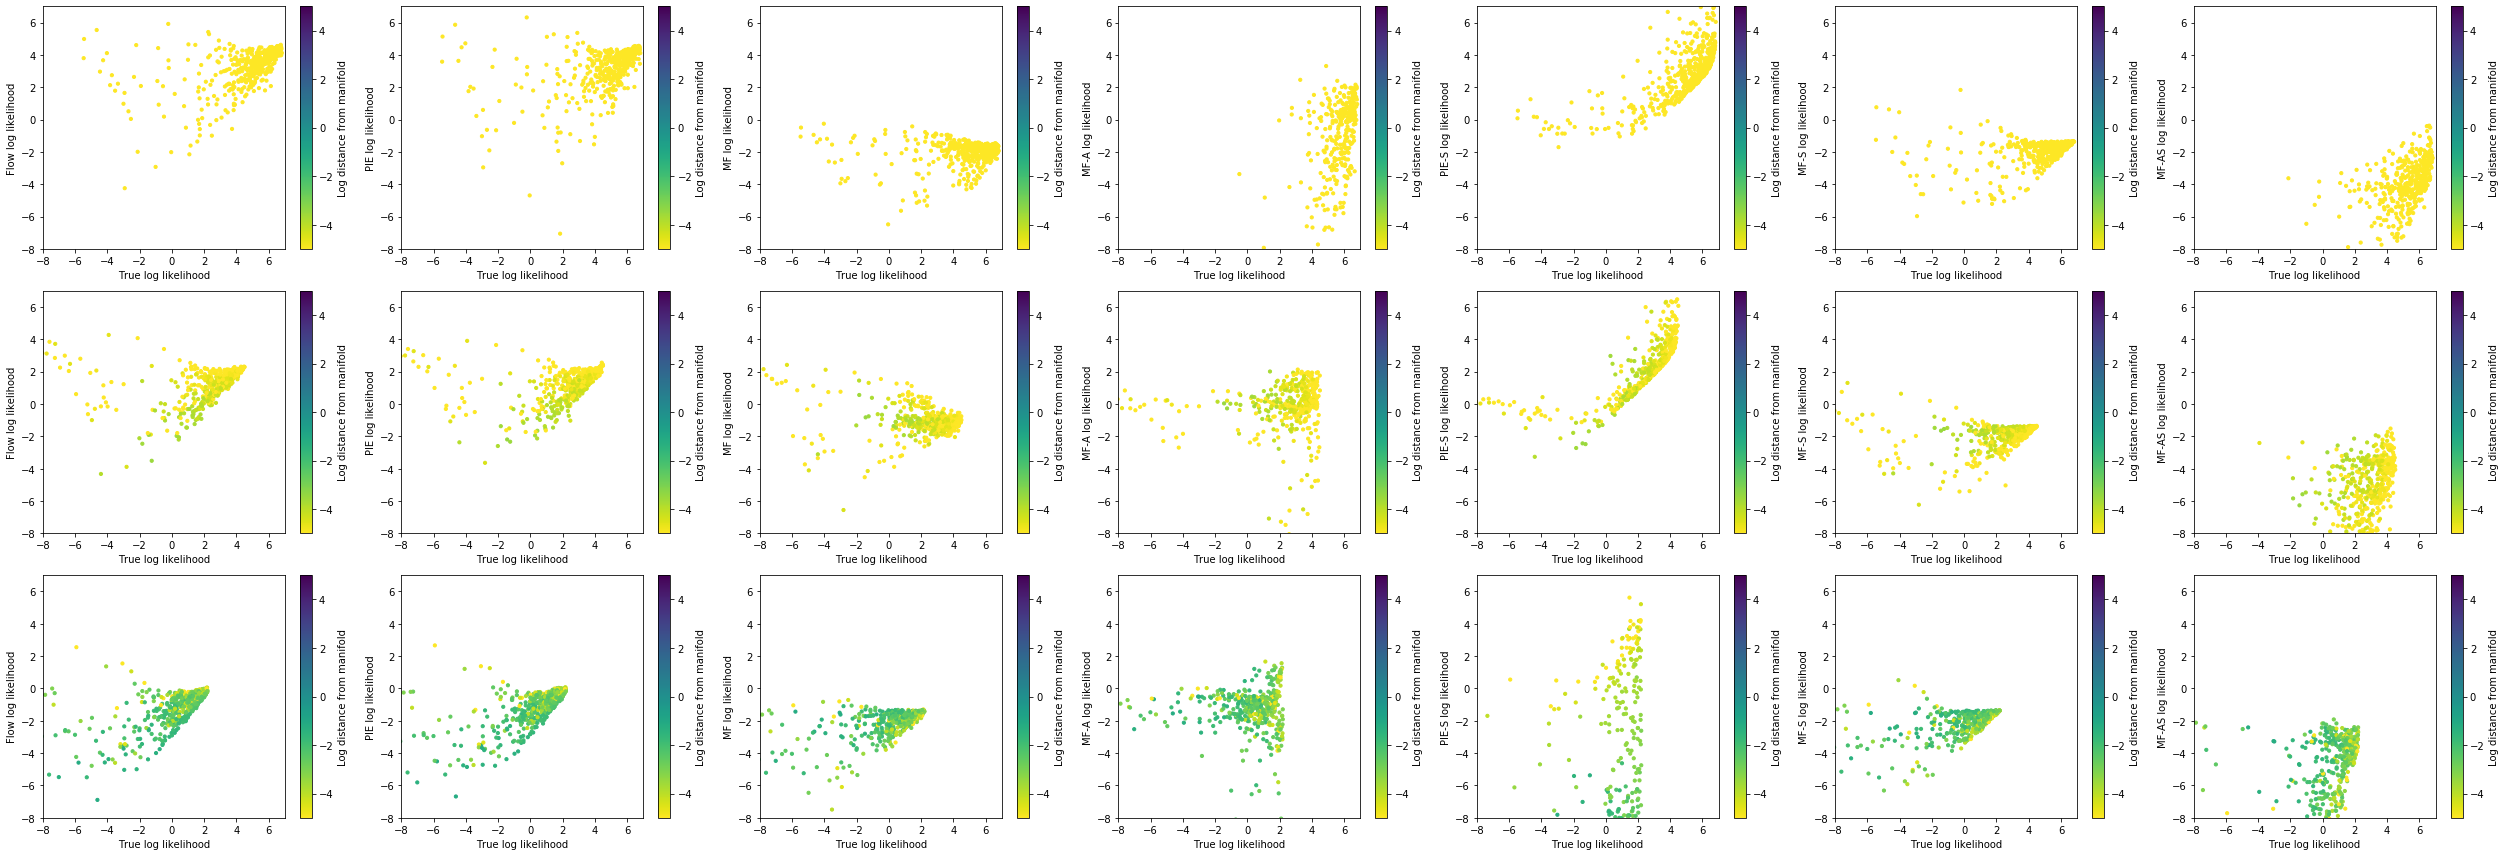

In [53]:
show = [1,0,2]

ncols = len(algo_labels)
nrows = len(show)

fig = plt.figure(figsize=(ncols*5, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(algo_labels):
        ax = plt.subplot(nrows, ncols, row*ncols + col + 1)
        
        sc = plt.scatter(
            true_test_log_likelihood[col, setting,:500],
            model_test_log_likelihood[col, setting,:500],
            c=np.log(np.clip(true_distances[setting,:500], np.exp(-10.), np.exp(10.))),
            s=10.,
            label=algo_label,
            cmap="viridis_r",
            vmin=-5, vmax=5
        )
        cbar = plt.colorbar(sc)
        
        plt.xlabel(r"True log likelihood")
        plt.ylabel(r"{} log likelihood".format(algo_label))
        cbar.set_label('Log distance from manifold')
        
        plt.xlim(-8.,7.)
        plt.ylim(-8.,7.)
    
plt.tight_layout()
plt.savefig("../figures/test_likelihood_scatter_spherical_gaussian.pdf")


## OOD detection

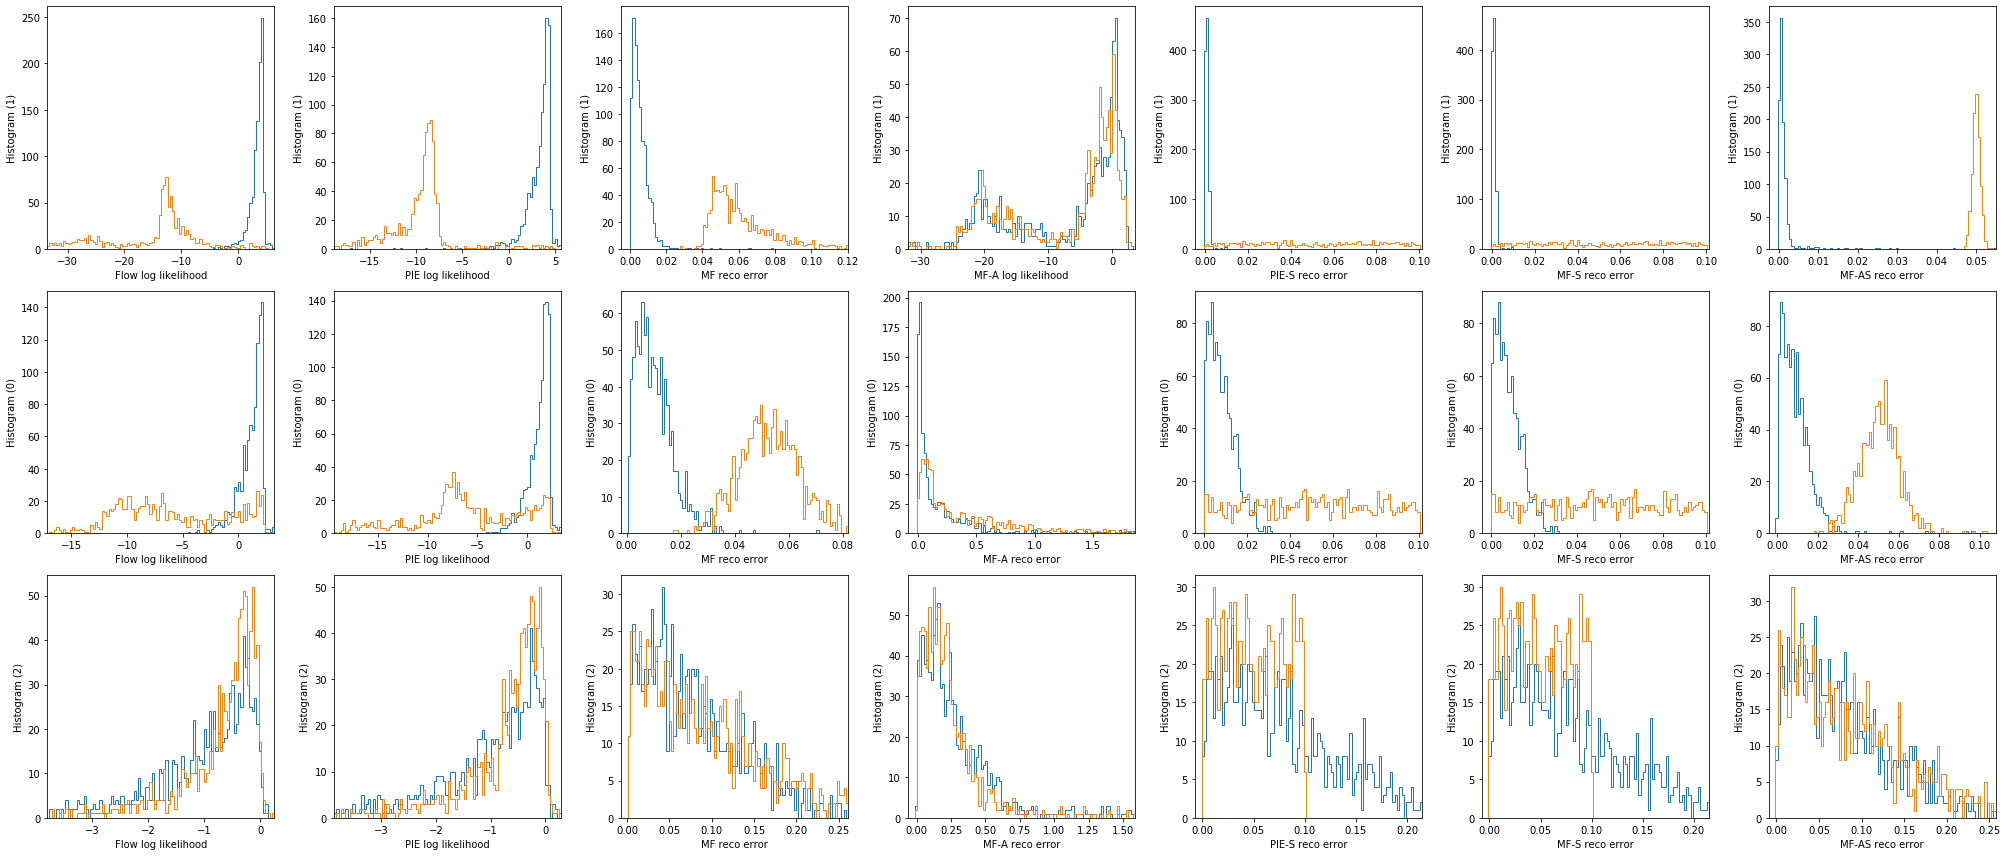

In [54]:
show = [1,0,2]

ncols = len(algo_labels)
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(algo_labels):
        ax = plt.subplot(nrows, ncols, row*ncols + col + 1)
        
        logp = model_test_log_likelihood[col, setting]
        logp_ood = model_ood_log_likelihood[col, setting]
        err = model_test_reco_error[col, setting]
        err_ood = model_ood_reco_error[col, setting]
        
        use_err = auc_use_err[col, setting]
        x = err if use_err else logp
        x_ood = err_ood if use_err else logp_ood
        xmin, xmax = np.percentile(np.concatenate((x, x_ood)), (2., 98.))
        xmin -= (xmax - xmin)*0.05
        xmax += (xmax - xmin)*0.05
        
        plt.hist(x, color="C0", bins=100, range=(xmin, xmax), histtype="step")
        plt.hist(x_ood, color="C1", bins=100, range=(xmin, xmax), histtype="step")
        
        plt.xlabel(("{} reco error" if use_err else "{} log likelihood").format(algo_label))
        plt.ylabel("Histogram ({})".format(setting))
        
        plt.xlim(xmin, xmax)
        plt.ylim(0., None)
    
plt.tight_layout()
plt.savefig("../figures/ood_separation_spherical_gaussian.pdf")



## Generative metrics

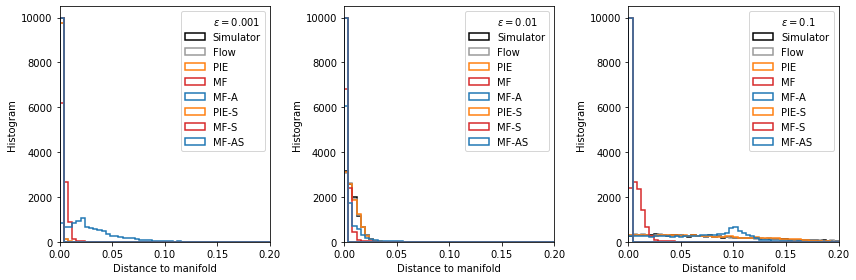

In [55]:
show = [1,0,2]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = 0.,0.2

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    plt.hist(
        true_distances[setting,:],
        range=(xmin, xmax), bins=50,
        label="Simulator",
        histtype="step",
        lw=1.5,
        color="black"
    )
    
    for algo, (algo_label, c, m) in enumerate(zip(algo_labels, algo_colors, algo_markers)):
        plt.hist(
            distance_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5,
            color=c
        )
        
    plt.legend()

    plt.xlabel(r"Distance to manifold")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    #plt.ylim(1., None)
    #plt.yscale("log")
    
plt.tight_layout()
plt.savefig("../figures/generated_samples_distance_distribution_spherical_gaussian.pdf")


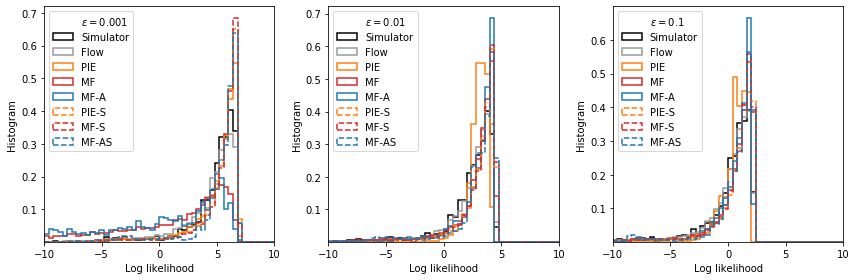

In [56]:
show = [1,0,2]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = -10.,10.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, (algo_label, c, m, ls) in enumerate(zip(algo_labels, algo_colors, algo_markers, algo_linestyles)):
        if algo == 0:
            plt.hist(
                true_test_log_likelihood[algo, setting,:],
                range=(xmin, xmax), bins=50,
                label="Simulator",
                histtype="step",
                lw=1.5,
                color="black",
                density=True,
                ls="-"
            )
        plt.hist(
            logp_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5,
            color=c,
                density=True,
                ls=ls
        )
        
    plt.legend(loc="upper left")

    plt.xlabel(r"Log likelihood")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/generated_samples_likelihood_distribution_spherical_gaussian.pdf")



## Summary plot

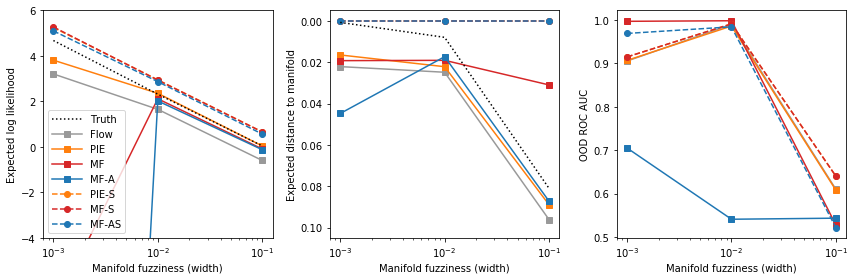

In [57]:
show = [1,0,2]
xs = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(12,4))

ax = plt.subplot(1,3,1)
plt.plot(xs, mean_logp_truth[show], label="Truth", ls=":", marker=" ", ms=6., c="black",zorder=5.)
for mean_logp_gen_, algo_label, c, m, ls in zip(mean_logp_gen, algo_labels, algo_colors, algo_markers, algo_linestyles):
    plt.plot(xs, mean_logp_gen_[show], label=algo_label, ls=ls, marker=m, ms=6., c=c)
plt.legend(handlelength=3.)
plt.xscale("log")
plt.ylim(-4., 6.)
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Expected log likelihood")

ax = plt.subplot(1,3,2)
for mean_distance_gen_, algo_label, c, m, ls in zip(mean_distance_gen, algo_labels, algo_colors, algo_markers, algo_linestyles):
    plt.plot(xs, mean_distance_gen_[show], label=algo_label, ls=ls, marker=m, ms=6, c=c)
plt.plot(xs, mean_distance_truth[show], label="Truth", ls=":", marker=" ", ms=6., c="black")
plt.xscale("log")
plt.ylim(0.105, -0.005)
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Expected distance to manifold")

ax = plt.subplot(1,3,3)
for auc, algo_label, c, m, ls in zip(auc_best, algo_labels, algo_colors, algo_markers, algo_linestyles):
    plt.plot(xs, auc, label=algo_label, ls=ls, marker=m, ms=6., c=c)
plt.xscale("log")
# plt.ylim(0.96, 1.002)
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("OOD ROC AUC")

plt.tight_layout()
plt.savefig("../figures/generated_samples_metrics_spherical_gaussian.pdf")
